In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import random
import plotly.express as px
import time
import seaborn as sns
sns.set_theme('talk', palette=sns.color_palette('Set2'))
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 150

## train data load

In [2]:
# infile = open('..//4_data_preparation_for_training//X_train','rb')
# X_train = pkl.load(infile)
# infile.close()

# infile = open('..//4_data_preparation_for_training//X_test','rb')
# X_test = pkl.load(infile)
# infile.close()

# infile = open('..//4_data_preparation_for_training//y_train','rb')
# y_train = pkl.load(infile)
# infile.close()

# infile = open('..//4_data_preparation_for_training//y_test','rb')
# y_test = pkl.load(infile)
# infile.close()

# X_train = X_train.values
# X_test = X_test.values
# y_train = y_train.values
# y_test = y_test.values

In [3]:
path = '/home/piotr/projects/apartment_price_estimator_v2'

with open(f'{path}/trainer/train_data/x_train.pkl','rb') as file:
    x_train = pkl.load(file)

with open(f'{path}/trainer/train_data/y_train.pkl','rb') as file:
    y_train = pkl.load(file)

with open(f'{path}/trainer/train_data/x_test.pkl','rb') as file:
    x_test = pkl.load(file)

with open(f'{path}/trainer/train_data/y_test.pkl','rb') as file:
    y_test = pkl.load(file)

for frame in [x_train,x_test]:
    frame.drop('date', axis=1, inplace=True)

for frame in [x_train,y_train,x_test,y_test]:
    frame = frame.values

## scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
x_train.shape, x_test.shape

((24612, 637), (6154, 637))

## creating model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation ,Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

2024-01-11 19:37:54.439960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model = Sequential()

model.add(Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_dim=x_test.shape[1]))
model.add(Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
model.add(Dense(4, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

2024-01-11 19:37:55.906270: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                20416     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           restore_best_weights=True)

In [10]:
start = time.time()

model.fit(x=x_train,y=y_train,
          validation_split=0.1,
          batch_size=256,epochs=1000,
#           callbacks=[early_stop],
         )

stop = time.time()
print('\n',round((stop-start)/60,2),'min.')

Epoch 1/1000
87/87 [==============================] - 1s 7ms/step - loss: 688771956736.0000 - val_loss: 671612272640.0000
Epoch 2/1000
87/87 [==============================] - 0s 5ms/step - loss: 688771760128.0000 - val_loss: 671612076032.0000
Epoch 3/1000
87/87 [==============================] - 0s 3ms/step - loss: 688771497984.0000 - val_loss: 671610830848.0000
Epoch 4/1000
87/87 [==============================] - 0s 3ms/step - loss: 688763699200.0000 - val_loss: 671589990400.0000
Epoch 5/1000
87/87 [==============================] - 0s 4ms/step - loss: 688703930368.0000 - val_loss: 671468617728.0000
Epoch 6/1000
87/87 [==============================] - 0s 2ms/step - loss: 688465838080.0000 - val_loss: 671074025472.0000
Epoch 7/1000
87/87 [==============================] - 0s 2ms/step - loss: 687826403328.0000 - val_loss: 670132076544.0000
Epoch 8/1000
87/87 [==============================] - 0s 2ms/step - loss: 686461485056.0000 - val_loss: 668265676800.0000
Epoch 9/1000
87/87 [====

In [11]:
losses = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Loss and validation loss')

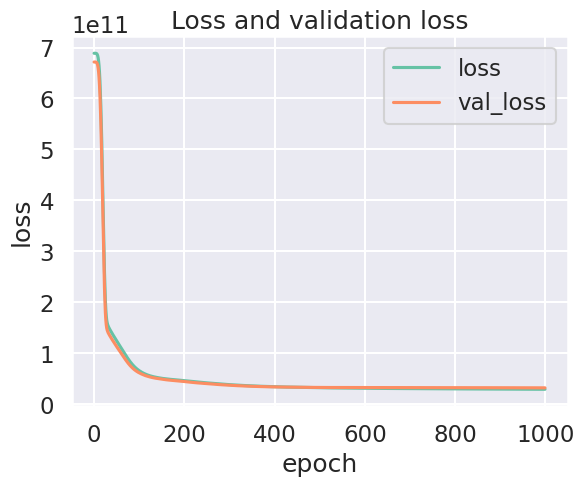

In [12]:
losses.plot()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss and validation loss')

(0.0, 100000000000.0)

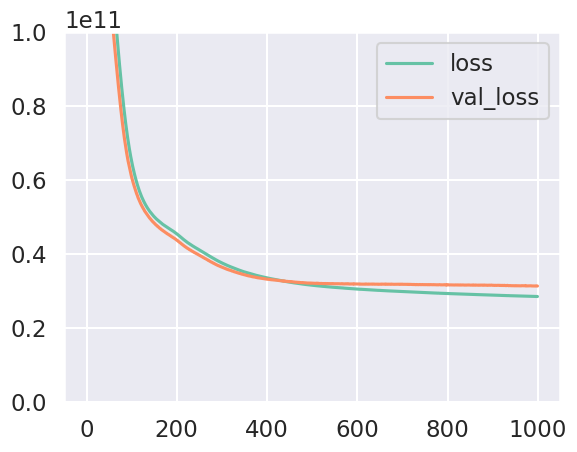

In [13]:
losses.plot()
plt.ylim(0,1e11)

## model evaluation

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

predictions = model.predict(x_test)
print(f'MAE\t{round(mean_absolute_error(y_test, predictions))}')
print(f'MSE\t{round(np.sqrt(mean_squared_error(y_test, predictions)))}')
print(f'R^2\t{round(r2_score(y_test, predictions),2)}')

193/193 [==============================] - 0s 960us/step
MAE	108375
MSE	179947
R^2	0.82


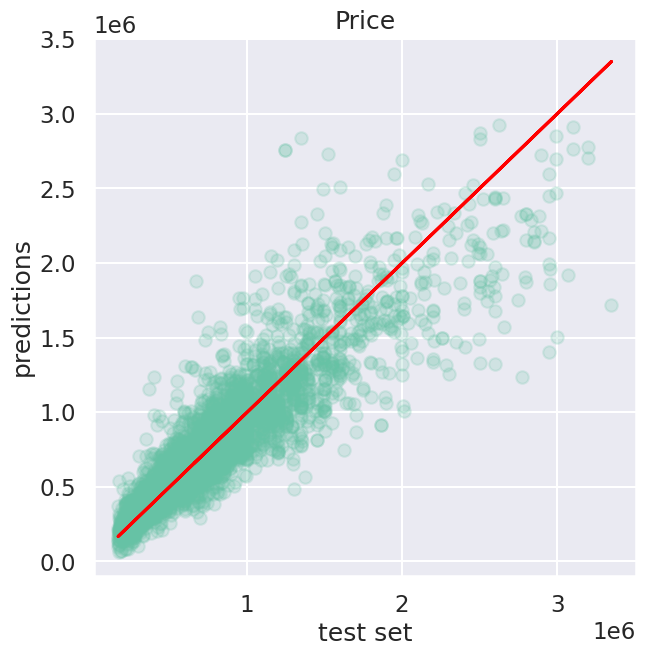

In [15]:
plt.figure(figsize=(7,7))
# plt.xlim(0,500)
# plt.ylim(0,500)

# Predictions
plt.scatter(x=y_test,y=predictions,edgecolor=None,alpha=0.2)
plt.xlabel('test set')
plt.ylabel('predictions')
plt.title('Price')

# Perfect predictions
plt.plot(y_test,y_test,'r')

Text(0.5, 1.0, 'Error distribution')

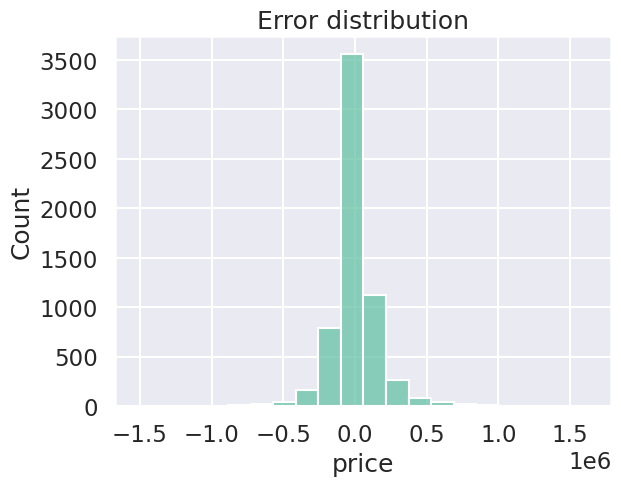

In [16]:
errors = y_test - predictions.reshape(y_test.shape[0])

# plt.xlim(-2e5,2e5)

sns.histplot(errors, bins=20)
plt.title('Error distribution')

Text(0.5, 1.0, 'Errors boxplot')

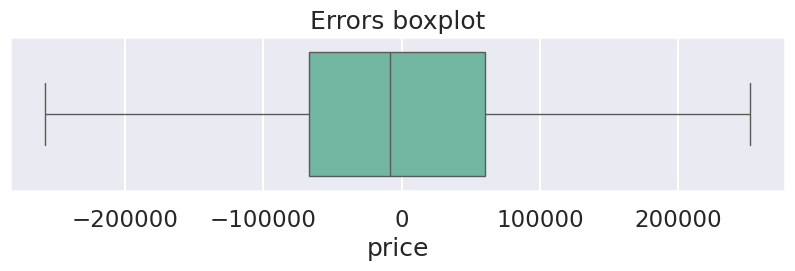

In [17]:
plt.figure(figsize=(10,2))
sns.boxplot(x=errors, showfliers=False)
plt.title('Errors boxplot')

In [18]:
predictions.reshape(y_test.shape[0])[:20]

array([ 829703.6 ,  350131.3 ,  665535.75, 2254982.  ,  634543.94,
        595816.44,  510565.2 ,  723933.5 ,  898732.5 , 1156955.8 ,
        681415.2 , 1692667.4 , 2326706.5 ,  847275.9 , 1199305.8 ,
        480679.78,  539435.94, 1456717.4 ,  407648.62, 1809614.5 ],
      dtype=float32)

In [19]:
y_test[:20]

id
27884     959000.0
24908     380000.0
25875     799000.0
23052    2415230.0
7328      599000.0
16027     629279.0
22142     379242.0
13412     754210.0
6693      937440.0
4704     1500000.0
648       650000.0
24029    1445360.0
27251    1450000.0
6559      876684.0
22254     789000.0
16680     600000.0
2109      591528.0
11790    1085000.0
29326     369000.0
17053    1300000.0
Name: price, dtype: float64

In [20]:
predictions.reshape(y_test.shape[0])[:20]/y_test[:20]

id
27884    0.865176
24908    0.921398
25875    0.832961
23052    0.933651
7328     1.059339
16027    0.946824
22142    1.346278
13412    0.959857
6693     0.958709
4704     0.771304
648      1.048331
24029    1.171104
27251    1.604625
6559     0.966455
22254    1.520033
16680    0.801133
2109     0.911936
11790    1.342597
29326    1.104739
17053    1.392011
Name: price, dtype: float64

## saving data

In [21]:
# from datetime import datetime
# from tensorflow.keras.models import load_model
# timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")
# model.save('ann_models\\' + 'ann_model_' + timestamp)

In [22]:
# import joblib
# joblib.dump(scaler, 'scaler')